## This notebook contains data standardization and various machine learning models, including a GridSearch to programatically try differnent hyperparameters

In [77]:
import pandas as pd
import numpy as np
from scipy.stats import skew, skewtest, boxcox
from scipy.special import inv_boxcox
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

#Need to specify fips as str to prevent losing leading 0s
df = pd.read_csv("./processeddata/census_health_citycounty_income_final.csv",dtype={"zips":str})
df.drop("Unnamed: 0", axis = 1, inplace = True)

%matplotlib inline

In [78]:
# Dropping Nas, would be better to figure out how to find missing income data by zipcode or impute somehow
# perhaps by using closest location where income was found for a zipcode
df = df.dropna(subset=["Median_Income_2017"])

In [79]:
## 5940 Samples to work with after cleaning
df.shape

(5973, 37)

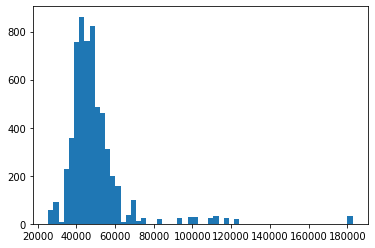

In [80]:
#Need to correct skep of median income 
plt.hist(df["Median_Income_2017"], bins=len(df["Median_Income_2017"])//100);

In [81]:
## These are the zipcodes that have incomes over 100K
## 95... referes to CA, 10... refers to NY, 06... refers to CT, 79... refers to Midland TX
df.loc[df["Median_Income_2017"] > 100_000]["zips"].values

array(['95054', '94104', '94104', '94102', '94102', '94103', '94103',
       '94102', '94102', '94102', '94102', '94102', '94102', '94103',
       '94103', '94103', '94103', '94103', '94102', '94104', '94105',
       '95054', '95054', '95050', '94401', '94401', '94401', '94401',
       '94401', '94401', '94402', '94402', '94402', '94402', '94402',
       '94402', '94403', '94403', '94403', '94403', '94403', '94401',
       '94401', '94401', '94403', '94404', '94404', '94403', '94403',
       '95054', '95054', '95054', '95050', '95050', '95051', '95051',
       '95050', '95051', '95051', '95051', '95051', '95051', '95050',
       '95050', '95050', '95050', '95050', '95051', '95051', '95051',
       '95051', '95051', '06605', '06605', '06605', '06604', '06604',
       '06604', '06604', '06605', '06604', '06604', '06604', '06608',
       '06604', '06608', '06604', '06604', '06606', '06606', '06606',
       '06606', '06606', '06606', '06606', '06606', '06608', '06608',
       '06608', '066

In [82]:
# While its never great to drop data, dropping the outliers where median income > 100k will help normalize our y values
df = df.loc[df["Median_Income_2017"] < 100_000]
df.reset_index(drop = True, inplace = True)

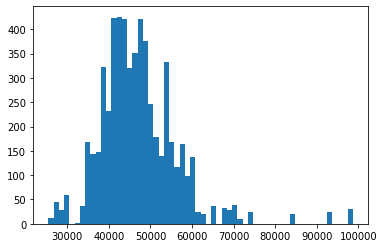

In [83]:
plt.hist(df["Median_Income_2017"], bins=len(df["Median_Income_2017"])//100);

In [84]:
print(skewtest(df["Median_Income_2017"]))

SkewtestResult(statistic=36.560988701214946, pvalue=1.1928911438993455e-292)


In [85]:
log_transform_array = np.log(df["Median_Income_2017"])
log10_transform_array = np.log10(df["Median_Income_2017"])
root_transform_array = np.sqrt(df["Median_Income_2017"])
box_cox_transform_array = boxcox(df["Median_Income_2017"])[0]

In [86]:
print(skewtest(log_transform_array))
print(skewtest(log10_transform_array))
print(skewtest(root_transform_array))
print(skewtest(box_cox_transform_array))
#BoxCox Transform provides the closest to a normal distribution
# After dropping extreme outliers areas with median income > 100K, a boxcox provides a normal distribution
# Pval means we can accept the null hypothesis that this data is randomly selected from a normal distribution

SkewtestResult(statistic=13.435909390622907, pvalue=3.7246437577148184e-41)
SkewtestResult(statistic=13.435909390623488, pvalue=3.7246437576856003e-41)
SkewtestResult(statistic=26.2288294564168, pvalue=1.2467034775683063e-151)
SkewtestResult(statistic=-1.3803715222576518, pvalue=0.16747228372155654)


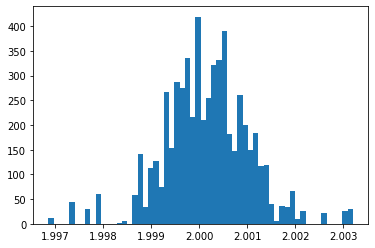

In [87]:
# BoxCox transform will normalize the data
plt.hist(box_cox_transform_array, bins=len(box_cox_transform_array)//100);

In [88]:
#This will be our y value
df["Median_Income_2017_norm"] = box_cox_transform_array

In [89]:
df.columns

Index(['BPHIGH', 'UniqueID', 'geometry', 'state', 'city_county', 'longitude',
       'latitude', 'tract_pop_count', 'BPMED', 'SLEEP', 'PHLTH', 'CHD',
       'DENTAL', 'CHOLSCREEN', 'BINGE', 'ARTHRITIS', 'DIABETES', 'KIDNEY',
       'CHECKUP', 'HIGHCHOL', 'STROKE', 'CANCER', 'OBESITY', 'LPA', 'MHLTH',
       'CASTHMA', 'CSMOKING', 'COPD', 'ACCESS2', 'PAPTEST', 'COLON_SCREEN',
       'MAMMOUSE', 'TEETHLOST', 'COREM', 'COREW', 'zips', 'Median_Income_2017',
       'Median_Income_2017_norm'],
      dtype='object')

In [90]:
df.head()

,BPHIGH,UniqueID,geometry,state,city_county,longitude,latitude,tract_pop_count,BPMED,SLEEP,...,ACCESS2,PAPTEST,COLON_SCREEN,MAMMOUSE,TEETHLOST,COREM,COREW,zips,Median_Income_2017,Median_Income_2017_norm
0,46.2,0107000-01073000100,"(33.5794328326, -86.7228323926)",AL,Birmingham,-86.722832,33.579433,3042.0,80.0,50.4,...,23.9,76.0,54.2,74.2,30.2,28.2,25.2,35206,48618.0,2.000421
1,55.1,0107000-01073000800,"(33.549697789, -86.8330944744)",AL,Birmingham,-86.833094,33.549698,3859.0,85.5,50.8,...,22.4,77.3,59.9,76.5,32.8,24.9,23.6,35207,48618.0,2.000421
2,49.5,0107000-01073001100,"(33.5429143325, -86.8756782852)",AL,Birmingham,-86.875678,33.542914,5354.0,84.4,48.4,...,16.8,82.3,66.6,80.0,23.8,28.3,28.1,35204,48618.0,2.000421
3,53.0,0107000-01073001200,"(33.5278767706, -86.8604161686)",AL,Birmingham,-86.860416,33.527877,2876.0,84.7,50.2,...,24.6,76.2,58.2,76.0,33.6,24.7,22.2,35204,48618.0,2.000421
4,53.6,0107000-01073001400,"(33.5261497258, -86.835146606)",AL,Birmingham,-86.835147,33.526150,2181.0,85.7,49.1,...,22.0,77.4,60.3,76.9,31.7,25.7,23.2,35204,48618.0,2.000421


In [92]:
feature_cols = [
    "BPHIGH", "OBESITY", "SLEEP", "BINGE"
]
feat_w_target_cols = deepcopy(feature_cols)
feat_w_target_cols.append("Median_Income_2017_norm")
X = df[feature_cols].dropna(subset=feature_cols)
y = df[feat_w_target_cols].dropna(subset=feature_cols)["Median_Income_2017_norm"]

In [95]:
len(y), X.shape[0]

(5651, 5651)

In [96]:
X.head() 

,BPHIGH,OBESITY,SLEEP,BINGE
0,46.2,46.7,50.4,10.1
1,55.1,47.4,50.8,8.9
2,49.5,43.7,48.4,9.6
3,53.0,47.0,50.2,9.4
4,53.6,45.8,49.1,8.9


In [97]:
y.head()

0    2.000421
1    2.000421
2    2.000421
3    2.000421
4    2.000421
Name: Median_Income_2017_norm, dtype: float64

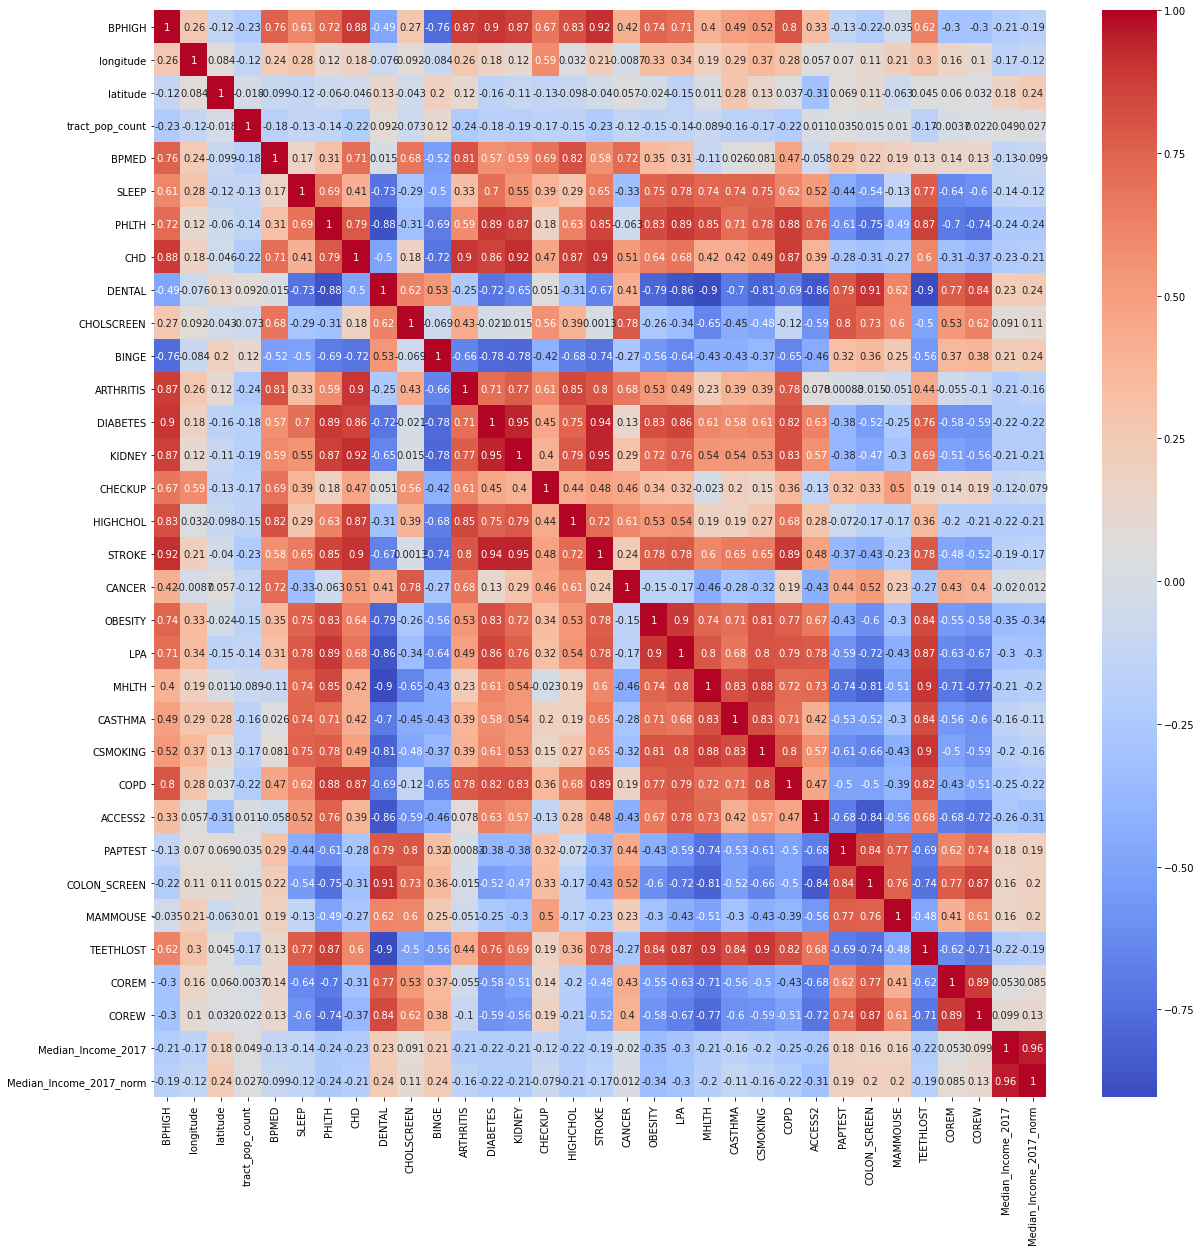

In [98]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(df.corr(), annot = True, ax= ax, cmap="coolwarm")
### looking at correlation between variables and per capita income

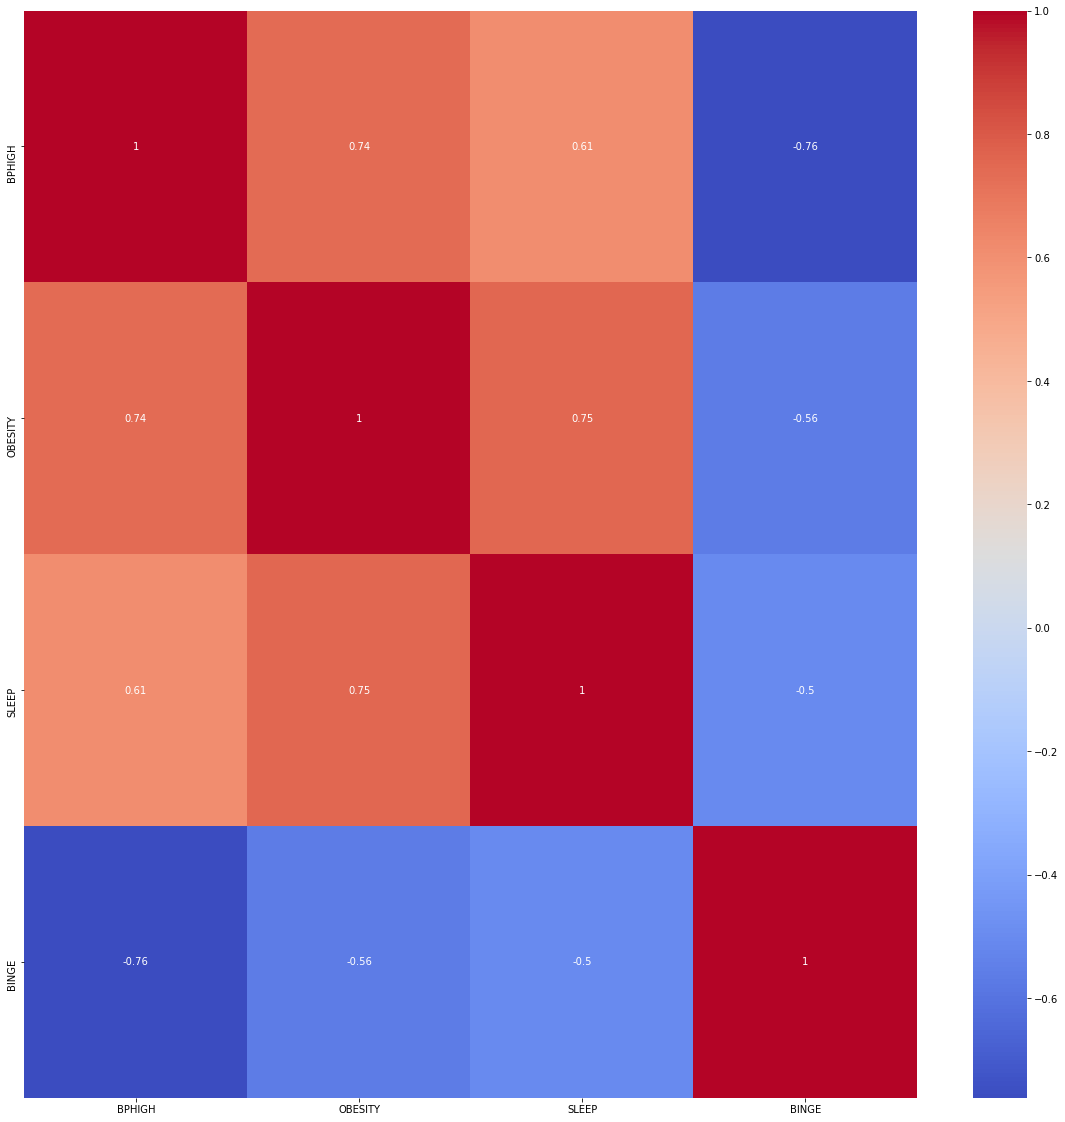

In [99]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(X.corr(), annot = True, ax= ax, cmap="coolwarm")
### looking at correlation between variables and per capita income

In [100]:
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.linear_model import ElasticNetCV, LassoCV

In [101]:
np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X,y) #train test split

In [102]:
X_train.shape, X_test.shape

((4238, 4), (1413, 4))

In [103]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test) # scale the features with scaler fit on training data

In [104]:
baseline_prediction_val = np.mean(y_train)
baseline_predictions = np.array([baseline_prediction_val for i in range(len(y_test))])

In [105]:
baseline_mse = mean_squared_error(y_test, baseline_predictions) ** .5

In [106]:
baseline_mse

0.000886214846373502

## Simple Linear Regression

In [107]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest

In [108]:
### originally used select K best, but model performed best using all features

In [109]:
lr = LinearRegression()
model = lr.fit(X_train_scaled, y_train)
preds = lr.predict(X_test_scaled)
mean_squared_error(y_test, preds) ** .5, baseline_mse

(0.0008121309622464084, 0.000886214846373502)

In [133]:
sample_predction = lr.predict(ss.transform([[10, 50, 10, 30]]))
"BPHIGH", "OBESITY", "SLEEP", "BINGE"

('BPHIGH', 'OBESITY', 'SLEEP', 'BINGE')

In [134]:
sample_predction

array([1.99768496])

In [110]:
np.std(model.coef_), np.mean(model.coef_) # used these values to create a standardized importance for the features below

(0.0003734597049832737, 4.029324006643391e-05)

In [135]:
model.intercept_

2.0001727242215375

In [111]:
coefs = pd.DataFrame({"features":X_train.columns, "coef": model.coef_})

In [113]:
coefs["importance"] = [x for  x in coefs.coef]

In [114]:
coefs.sort_values("importance", ascending=False).set_index("features", drop = True) # dataframe of feature importance

,coef,importance
features,,
SLEEP,0.000302,0.000302
BPHIGH,0.000253,0.000253
BINGE,0.000210,0.000210
OBESITY,-0.000604,-0.000604


## Random Forest With Gridsearch

In [ ]:
rf = RandomForestRegressor()
params = {"n_estimators":[3,7,10,12,15],
         "max_depth":[None,7,5,3],
         "min_samples_split":[2,3,4],
         "min_samples_leaf":[1,2],
         "n_jobs":[4]}

In [ ]:
gs = GridSearchCV(estimator=rf, param_grid=params)

In [ ]:
gs.fit(X_train_scaled,y_train)

In [ ]:
gs.best_params_

In [ ]:
preds = gs.predict(X_test_scaled)

In [ ]:
mean_squared_error(y_test, preds) ** .5

## Lasso

In [ ]:
las = LassoCV(n_jobs=4, max_iter=15000)
las.fit(X_train_scaled, y_train)
preds = las.predict(X_test_scaled)
mean_squared_error(y_test, preds)** .5